# Querying the MRIQC Web API

This notebook shows how the web-API can be leveraged to analyze the image quality metrics (IQMs) that have been extracted with MRIQC

This notebook is a derivative work of https://gist.github.com/chrisfilo/eccdb8b98f8e74d24a3395a49fbadf03

In [1]:
import os
import sys
import pandas as pd
from json import load
import urllib.request, json 
from pandas.io.json import json_normalize
import seaborn as sns
import pylab as plt
import multiprocessing as mp
import numpy as np
from dateutil import parser

%matplotlib inline

## Preparation

Let's define a function that will query the appropriate endpoint and a helper function to plot some distributions (at the bottom of this notebook).

In [3]:
def get_iqms(modality, versions=None, software='mriqc', out_file=None, page_size=25):
    """
    Grab all iqms for the given modality and the list of versions
    """
    url_root = 'https://mriqc.nimh.nih.gov/api/v1/{modality}?{query}'
    page = 1
    
    if out_file is None:
        out_file = 'webapi-%s.csv' % modality
    
    database = pd.DataFrame()
    if os.path.isfile(out_file):
        database = pd.read_csv(out_file)
        page = len(database) // page_size + 1
        print('Found old records. Starting on page ', page)

    if versions is None:
        versions = ['*']

    for version in versions:
        while True:
            query = 'max_results=%d&page=%d' % (page_size, page)
            
            filters = []
            if software is not None:
                filters.append('"provenance.software":"%s"' % software)
            
            if version != '*':
                filters.append('"provenance.version":"%s"' % version)
            
            if filters:
                query += '&where={%s}' % ','.join(filters)
                
            page_url = url_root.format(
                modality=modality,
                query=query
            )
            with urllib.request.urlopen(page_url) as url:
                data = json.loads(url.read().decode())
                database = database.append(
                    json_normalize(data['_items']), sort=False)
                
                database.to_csv(out_file)
                sys.stdout.write('.')
                sys.stdout.flush()
                if 'next' not in data['_links'].keys():
                    break
                else:
                    page += 1

    database.to_csv(out_file)
    return database


def plot_measure(data, xlabel=None, label=None, ax=None, min=None, max=None):
    """
    Distribution plot of a given measure
    """
    sns.distplot(data, ax=ax, label=label)
    
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    
    if min is None:
        min = np.percentile(data, 0.5)
    
    if max is None:
        max = np.percentile(data, 99.5)
    ax.set_xlim((min, max))

## Fetch IQMs

Let's fetch IQMs for the two principal modalities of MRIQC, T1-weighted images and BOLD-fMRI. Filter out repeated images to obtain unique records.

In [4]:
# T1
df_t1w = get_iqms('T1w', software=None, out_file='20180531-T1.csv', page_size=1000)
df_t1w_unique = df_t1w.drop_duplicates(subset=['provenance.md5sum'])

..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [5]:
# BOLD
df_bold = get_iqms('bold', out_file='20180531-bold.csv', page_size=1000)
df_bold_unique = df_bold.drop_duplicates(subset=['provenance.md5sum'])

.............................................................................

In [8]:
len(df_t1w_unique), len(df_t1w)

(46104, 849303)

## Evolution of IQMs submission

This code generates Figure 3A of the abstract

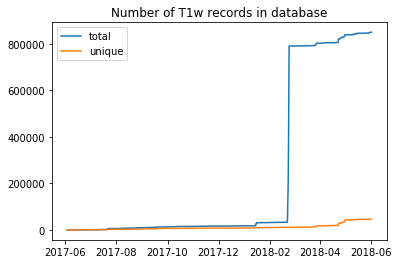

In [9]:
import datetime
from dateutil import parser
import matplotlib.dates as mdates

dates_t1w = [parser.parse(d) for d in df_t1w['_created'].values]
dates_t1w.sort()

dates_t1w_u = [parser.parse(d) for d in df_t1w_unique['_created'].values]
dates_t1w_u.sort()
# mindate = dates_t1w[0]
ax = plt.subplot(111)
ax.plot(dates_t1w, list(range(1, len(dates_t1w) + 1)), label='total')
ax.plot(dates_t1w_u, list(range(1, len(dates_t1w_u) + 1)), label='unique')
ax.set_title('Number of T1w records in database')
ax.legend()

plt.savefig("fig03a-0.svg", bbox_inches='tight', transparent=False, pad_inches=0)

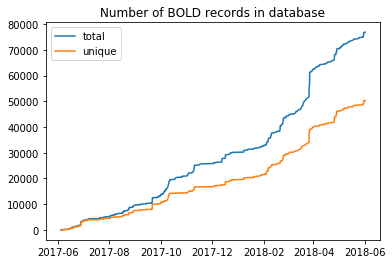

In [10]:
dates_bold = [parser.parse(d) for d in df_bold['_created'].values]
dates_bold.sort()
dates_bold_u = [parser.parse(d) for d in df_bold_unique['_created'].values]
dates_bold_u.sort()
# mindate = dates_t1w[0]
ax = plt.subplot(111)
ax.plot(dates_bold, list(range(1, len(dates_bold) + 1)), label='total')
ax.plot(dates_bold_u, list(range(1, len(dates_bold_u) + 1)), label='unique')
ax.set_title('Number of BOLD records in database')
ax.legend()
plt.savefig("fig03a-1.svg", bbox_inches='tight', transparent=False, pad_inches=0)

## Playing with T1w IQMs

Let's plot some of the IQMs for the T1w modality. First, let's check the names of the IQMs. These measures are explained in the documentation (http://mriqc.readthedocs.io/en/stable/iqms/t1w.html)

In [11]:
print(','.join([l for l in df_t1w.columns 
                if not l.startswith('_') and not l.startswith('bids_meta') and not l.startswith('provenance')]))

cjv,cnr,efc,fber,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,icvs_csf,icvs_gm,icvs_wm,inu_med,inu_range,qi_1,qi_2,rpve_csf,rpve_gm,rpve_wm,size_x,size_y,size_z,snr_csf,snr_gm,snr_total,snr_wm,snrd_csf,snrd_gm,snrd_total,snrd_wm,spacing_x,spacing_y,spacing_z,summary_bg_k,summary_bg_mad,summary_bg_mean,summary_bg_median,summary_bg_n,summary_bg_p05,summary_bg_p95,summary_bg_stdv,summary_csf_k,summary_csf_mad,summary_csf_mean,summary_csf_median,summary_csf_n,summary_csf_p05,summary_csf_p95,summary_csf_stdv,summary_gm_k,summary_gm_mad,summary_gm_mean,summary_gm_median,summary_gm_n,summary_gm_p05,summary_gm_p95,summary_gm_stdv,summary_wm_k,summary_wm_mad,summary_wm_mean,summary_wm_median,summary_wm_n,summary_wm_p05,summary_wm_p95,summary_wm_stdv,tpm_overlap_csf,tpm_overlap_gm,tpm_overlap_wm,wm2max


/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/oesteban/.anaconda

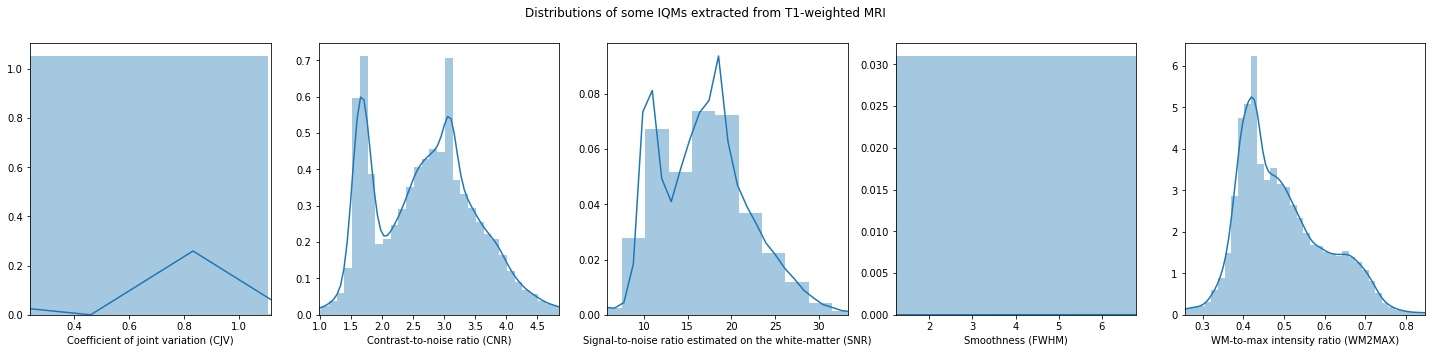

In [12]:
f, ax = plt.subplots(1, 5, figsize=(25,5))
plot_measure(df_t1w_unique.cjv, xlabel='Coefficient of joint variation (CJV)', ax=ax[0])
plot_measure(df_t1w_unique.cnr, xlabel='Contrast-to-noise ratio (CNR)', ax=ax[1])
plot_measure(df_t1w_unique.snr_wm, xlabel='Signal-to-noise ratio estimated on the white-matter (SNR)', ax=ax[2])
plot_measure(df_t1w_unique.fwhm_avg, xlabel='Smoothness (FWHM)', ax=ax[3])
plot_measure(df_t1w_unique.wm2max, xlabel='WM-to-max intensity ratio (WM2MAX)', ax=ax[4])
plt.suptitle('Distributions of some IQMs extracted from T1-weighted MRI')
plt.savefig("fig03b-0.svg", bbox_inches='tight', transparent=False, pad_inches=0)

## Playing with BOLD IQMs

Let's plot some of the IQMs for the BOLD modality. First, let's check the names of the IQMs. These measures are explained in the documentation (http://mriqc.readthedocs.io/en/stable/iqms/bold.html)

In [13]:
print(','.join([l for l in df_bold.columns 
                if not l.startswith('_') and not l.startswith('bids_meta') and not l.startswith('provenance')]))

aor,aqi,dummy_trs,dvars_nstd,dvars_std,dvars_vstd,efc,fber,fd_mean,fd_num,fd_perc,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,gcor,gsr_x,gsr_y,size_t,size_x,size_y,size_z,snr,spacing_tr,spacing_x,spacing_y,spacing_z,summary_bg_k,summary_bg_mad,summary_bg_mean,summary_bg_median,summary_bg_n,summary_bg_p05,summary_bg_p95,summary_bg_stdv,summary_fg_k,summary_fg_mad,summary_fg_mean,summary_fg_median,summary_fg_n,summary_fg_p05,summary_fg_p95,summary_fg_stdv,tsnr


/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


ValueError: cannot convert float NaN to integer

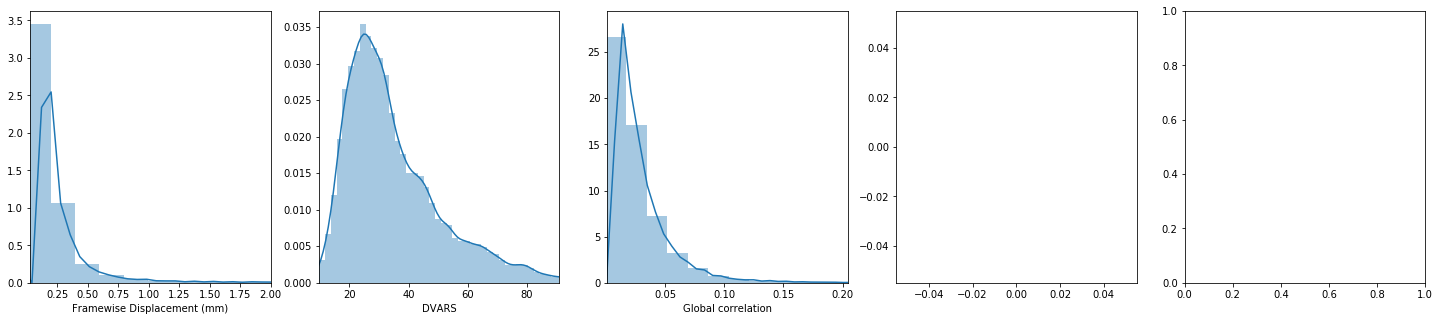

In [14]:
f, ax = plt.subplots(1, 5, figsize=(25,5))
plot_measure(df_bold_unique[df_bold_unique.fd_mean < 10].fd_mean, xlabel='Framewise Displacement (mm)', max=2, ax=ax[0])
plot_measure(df_bold_unique[df_bold_unique.dvars_nstd < 100].dvars_nstd, xlabel='DVARS', ax=ax[1])
plot_measure(df_bold_unique.gcor, xlabel='Global correlation', ax=ax[2])
plot_measure(df_bold_unique.gsr_x, label='x-axis', ax=ax[3])
plot_measure(df_bold_unique.gsr_y, xlabel='Ghost-to-signal ratio (GSR)', label='y-axis', ax=ax[3])
ax[3].legend()
plot_measure(df_bold_unique.tsnr, xlabel='Temporal SNR (tSNR)', ax=ax[4])
plt.suptitle('Distributions of some IQMs extracted from BOLD fMRI')
plt.savefig("fig03b-1.png", bbox_inches='tight', transparent=False, pad_inches=0, facecolor='white')